# CS 4820
# Tutorial 7: MNIST - pixels as features

### MNIST

The [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) is a very famous dataset of handwritten digits and it has become a benchmark for image recognition algorithms. It consists of 70,000 images of 28 pixel by 28 pixels, each representing a handwritten digit.

> TIP: Think of how many real-world applications involve recognition of handwritten digits:
- zipcodes
- tax declarations
- student tests
- ...

The target variables are the ten digits from 0 to 9.

Keras has it's built-in dataset for MNIST, so we will load it from there using the `load_data` function

In [1]:
from tensorflow.keras.datasets import mnist

# allow multiple outputs be displayed for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 16s 1us/step


Let's check the shape of the arrays of the data we received for the training and test sets:

In [3]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(60000, 28, 28)

(60000,)

(10000, 28, 28)

(10000,)

The loaded data is a numpy array of order 3. It's like a 3-dimensional matrix, whose elements are identified by 3 indices.

For now, it is sufficient to know that the first index (running from 0 to 59999 for X_train) locates a specific image in the dataset, while the other two indices determine a particular pixel in the picture, i.e., they run from 0 to the height and width of the image.

For instance, we can select the first image in the training set and take a look at its shape by using the first index:

In [4]:
first_img = X_train[0]

This image is a 2D array of numbers between 0 and 255, like this:

![The first number in the mnist training set is a 5](./assets/mnist_0.png)

Let's use `plt.imshow` once again to display the image:

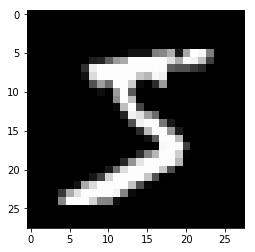

In [6]:
import matplotlib.pyplot as plt

plt.imshow(first_img, cmap='gray');

Notice that with the `gray` colormap, zeros are displayed as black pixels while higher numbers are displayed as lighter pixels.

### Pixels as features

How can we use this whole image as an input to a classification model?

So far our input datasets have always been 2D tabular sets, where table columns refer to different features and each data point occupies a row. In this case, each data point is itself a 2D table (an image), and so we need to decide how to map it to features. 

The simplest way to feed images to a Neural Network model is to use each pixel in the picture as an individual feature. If we do this, we will have $28 \times 28 = 784$ independent features, each one being an integer between 0 and 255, and our dataset will become tabular once again. Each row in the tabular dataset will represent a different image, and each of the 784 columns will designate a specific pixel.

The `reshape` method of a numpy array allows us to reshape any array to a new shape. For example, let's reshape the training dataset to be a tabular dataset with 60000 rows and 784 columns:

In [7]:
X_train_flat = X_train.reshape((60000, 784))

We can check that the operation worked by printing the shape of `X_train_flat`:

In [8]:
X_train_flat.shape

(60000, 784)

Wonderful! Another valid syntax for `reshape` is to just specify the size of the dimensions we care about and let the method figure out the other dimension, like this:

In [9]:
X_test_flat = X_test.reshape(-1, 28*28)
X_test_flat.shape

(10000, 784)

Great! Now we have 2 tabular datasets like the ones we are familiar with. The features contain values between 0 and 255:

In [10]:
X_train_flat.min()
X_train_flat.max()

0

255

As already seen before, Neural Network models are quite sensitive to the absolute size of the input features, and hence they like features that are normalized to be somewhat between 0 and 1. 

We should rescale the values of our features to be between 0 and 1. Lets do it by dividing them by 255 so they will have values between 0 and 1. Notice that we need to convert the the data type to `float32` because under the hood numpy arrays are implemented in C and therefore are strongly typed.

> Also, notice that we are not using `StandardScaler` that we used before because it would generate some negtive values, which we don't necessarily like here.

In [11]:
X_train_sc = X_train_flat.astype('float32') / 255.0
X_test_sc = X_test_flat.astype('float32') / 255.0

Hotdog! We now have 2D data that we can use to train a fully connected Neural Network!

### One-hot encoding the multiclass output

Since there are ten possible output classes, this is a Multiclass classification problem where the outputs are mutually exclusive. As we have learned before, we need to convert the labels (aka. targets) to a matrix of binary columns. In doing so, we communicate to the network that the labels are distinct and it should learn to predict the probability of an image to correspond to a specific label.

In other words, our goal is to build a network with 784 inputs and 10 outputs, like the one represented in this figure so that for a given input image the network learns to indicate to which label it corresponds: 

![Fully connected network to solve MNIST](./assets/mnist_fc.png)

Therefore we need to make sure that the shape of the label array matches the output of our network.

We can convert our labels to binary arrays using the `to_categorical` utility function from `tensorflow.keras`. Let's import it before using it.

In [12]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


y_train_cat.shape
y_test_cat.shape

# As you can see, this is an array of 10 numbers, zero everywhere except at position 5 
# (remember we start counting from 0) indicating which of the 10 classes our image should be classified as.
y_train_cat[0] 

(60000, 10)

(10000, 10)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Fantastic! We can now train a fully connected Neural Network using all what we've learned in the previous chapters.

### Fully connected on images

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Now let's build the model.

The network configuration will be the following:

- Input: 784 features
- Layer 1: 512 nodes with Relu activation
- Layer 2: 256 nodes with Relu activation
- Layer 3: 128 nodes with Relu activation
- Layer 4: 32 nodes with Relu activation
- Output Layer: 10 nodes with Softmax activation

Notice a number of things:

1. We specify the size of the input in the definition of the first layer through the parameter `input_dim=784`.
- The choice of the number of layers and the number of nodes per layer is arbitrary. Feel free to experiment with different architectures and observe:
    - if the network performs better or worse
    - if the training takes longer or shorter (number of epochs to reach a certain accuracy)
- The last layer added to the stack is also the output layer. Make sure that the number of nodes in the last layer in the stack corresponds to the number of categories in your dataset
- The last layer has a `Softmax` activation function at its output. As seen before, this is needed when the classes are mutually exclusive. In this case, an image of a digit cannot be of 2 different digits at the same time, and we need to let the model know about it.
- Finally, the model is compiled using the `categorical_crossentropy` loss, which is the correct one for classifications with many mutually exclusive classes.

In [14]:
model = Sequential()

model.add(Dense(512, input_dim=784, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))  # output

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Let's print out the model summary (can you figure out how the "Param #" are calculated?):

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 570,602
Trainable params: 570,602
Non-trainable params: 0
_________________________________________________________________


As you can see, the model has about half a million parameters, namely 570,602.

Let's train it on our data for ten epochs with 128 images per batch. We will need to pass the _scaled inputs and reshaped_ outputs.

Also, let's use a `validation_split` of 10%, meaning we will train the model on 90% of the training data, and evaluate its performance on the remaining 10%. This is like an internal train/test split done on the training data. It's useful when we plan to change the network and tune its architecture to maximize its ability to generalize. We will keep the actual test set for a final check once we have committed to the best architecture.

In [16]:
h = model.fit(X_train_sc, y_train_cat, batch_size=128,
              epochs=10, verbose=1,
              validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 6s 110us/sample - loss: 0.2858 - accuracy: 0.9120 - val_loss: 0.1093 - val_accuracy: 0.9663
Epoch 2/10
54000/54000 [==============================] - 5s 98us/sample - loss: 0.1023 - accuracy: 0.9691 - val_loss: 0.0809 - val_accuracy: 0.9742
Epoch 3/10
54000/54000 [==============================] - 5s 98us/sample - loss: 0.0676 - accuracy: 0.9797 - val_loss: 0.0676 - val_accuracy: 0.9817
Epoch 4/10
54000/54000 [==============================] - 5s 99us/sample - loss: 0.0499 - accuracy: 0.9848 - val_loss: 0.0810 - val_accuracy: 0.9783
Epoch 5/10
54000/54000 [==============================] - 5s 98us/sample - loss: 0.0381 - accuracy: 0.9889 - val_loss: 0.0888 - val_accuracy: 0.9788
Epoch 6/10
54000/54000 [==============================] - 5s 99us/sample - loss: 0.0306 - accuracy: 0.9904 - val_loss: 0.0762 - val_accuracy: 0.9818
Epoch 7/10
54000/54000 [==============================] 

The model seems to be doing very well on the training data (as we can see by the `accuracy` output). 

Let's check if it is overfitting, i.e., if it is just memorizing the answers instead of learning general rules about the training examples.

Let's plot the history of the accuracy and compare the training accuracy with the validation accuracy.

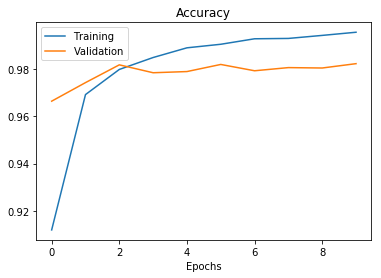

In [17]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs');

We already notice that while the training accuracy increases, the validation accuracy does not seem to increase as well. Let's check the performance on the test set:

In [18]:
test_acc = model.evaluate(X_test_sc, y_test_cat)[1]

test_acc

10000/10000 [==============================] - 1s 83us/sample - loss: 0.1114 - accuracy: 0.9799


0.9799

and let's compare it with the performance on the training set:

In [19]:
train_acc = model.evaluate(X_train_sc, y_train_cat)[1]
train_acc

60000/60000 [==============================] - 5s 76us/sample - loss: 0.0190 - accuracy: 0.9958


0.9958

The performance on the test set is lower than the performance on the training set. 

> TIP: one question you may have is "When is a difference between the test and train scores significant". We can answer this question by running cross-validation to see what the standard deviation of each score is. Then we can compare their difference between the two scores with the standard deviation and see if their difference is much higher than the statistical fluctuations of each score.

This difference between the train and test scores may indicate we are overfitting.

This indication makes sense because the model is trained using the individual pixels as features. This implies that two images which are similar but slightly rotated or shifted have entirely different features.

> To go beyond "pixels as features" we need to extract better features from the images and use a more specialized model such as Convolutional Neural Net (CCN). More on this subject later.

__More tests__

In [ ]:
import numpy as np

y_pred=model.predict(X_test_sc)

y_test_class=np.argmax(y_test_cat, axis=1)
y_pred_class=np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_class, y_pred_class))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

cm = confusion_matrix(y_test_class, y_pred_class)

import matplotlib.pyplot as plt

plt.imshow(cm, cmap='Blues');

y_test.shape

In [ ]:
print('Test accuracy for our ANN model:', \
      round(accuracy_score(y_test_class, y_pred_class)*100, 2),'%')

The test accuracy 98.24% is the same as what we obtained using `model.evaluate()` above.